<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> CC3104 - Aprendizaje por Refuerzo 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 5:</strong> Time Difference Learning</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
      </ul>
    </td>
  </tr>
</table>

## 📝 Task 1

**1. Defina y explique qué “expected sarsa”**
**a. ¿Cómo se diferencia de “sarsa”?**
**b. ¿Para qué sirven las modificaciones que se hacen sobre “sarsa”?**

- Expected SARSA es una variante del algoritmo original en el que, en vez de actualizar el valor Q usando solamente la acción que se tomó en el siguiente estado, este utiliza el valor esperado de todas las acciones posibles de ese estado, siendo ponderado por la probabilidad de que cada una sea elegida según la política actual. Su diferencia con sarsa se da en que, en lugar de tomar Q(s', a'), toma la sumatoria de todos los valores Q de todas las acciones en s'. Su utilidad en las modificaciones se da en reducir la varianza de la estimación por cada iteración, suavizando el aprendizaje.

**2. Defina y explique qué es “n-step TD”**
**a. ¿Cómo se diferencia de TD(0)?**
**b. ¿Cuál es la utilidad de esta modificación?**
**c. ¿Qué usa como objetivo?**

- Es un método de Temporal Difference que actualiza los valores Q utilizando el retorno acumulado de n-pasos en el futuro, en vez de hacerlo solo con uno. La diferencia de TD(0) es que n-step TD utiliza la suma de recompensas de los siguientes n-pasos más el valor estimado en el estado alcanzado. Su utilidad permite un balance entre el sesgo que se puede generar y la varianza, considerando los valores pequeños y grandes de n. El objetivo que usa es el propio retorno de n-step.



**3. ¿Cuál es la diferencia entre SARSA y Q-learning?**

- SARSA es un algoritmo de naturaleza on-policy que aprende el valor Q siguiendo la política mientras esta se está evaluando y mejorando. Mientras que, Q-Learning, por otro lado, es de naturaleza off-policy, y este aprende el valor Q de la política óptima independientemente de la que se siga para explorar.

## 📝 Task 2

En este laboratorio, compararán el rendimiento de SARSA y Q-Learning, dos algoritmos de aprendizaje de refuerzo populares, utilizando el entorno CliffWalking-v0 de la biblioteca Gymnasium. Analizará y graficará las recompensas por episodio y responderá preguntas para profundizar su comprensión de las diferencias entre estos algoritmos.

**Instalar las bibliotecas necesarias**

In [33]:
!pip install matplotlib
!pip install gymnasium==0.28.1


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.envs.toy_text.cliffwalking import CliffWalkingEnv


**Inicialice el entorno**

In [35]:
gym.envs.registration.register(
    id="CliffWalking-v0",
    entry_point="gymnasium.envs.toy_text.cliffwalking:CliffWalkingEnv",
)

env = gym.make("CliffWalking-v0")

n_states = env.observation_space.n
n_actions = env.action_space.n

# Parámetros por defecto
ALPHA = 0.5         # tasa de aprendizaje
GAMMA = 0.99        # factor de descuento
EPSILON = 0.1       # épsilon para política epsilon-greedy
EPISODES = 500      # cantidad de episodios
SEED = 24

# Semillas
np.random.seed(SEED)
env.reset(seed=SEED)

print(f"Entorno de CliffWalking-v0 | Estados: {n_states} | Acciones: {n_actions}")

Entorno de CliffWalking-v0 | Estados: 48 | Acciones: 4


In [36]:
def epsilon_greedy_action(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    return np.argmax(Q[state])

def make_epsilon_schedule(epsilon_start, epsilon_end=None, decay_episodes=None):
    if epsilon_end is None or decay_episodes is None or decay_episodes <= 0:
        return lambda ep: epsilon_start
    
    def schedule(ep):
        t = min(ep / decay_episodes, 1.0)
        return (1 - t) * epsilon_start + t * epsilon_end
    return schedule

**Implementar SARSA**

In [37]:
def train_sarsa(env, episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
                epsilon=EPSILON, max_steps=500, epsilon_schedule=None, seed=SEED):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    rewards_per_episode = []

    np.random.seed(seed)

    for ep in range(episodes):
        eps = epsilon_schedule(ep) if epsilon_schedule else epsilon
        state, info = env.reset(seed=seed + ep)
        action = epsilon_greedy_action(Q, state, eps)

        total_reward = 0.0

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward

            # Elegir siguiente acción con la misma política
            next_action = epsilon_greedy_action(Q, next_state, eps)

            # Actualización de SARSA
            td_target = reward + gamma * Q[next_state, next_action] * (1 - int(terminated or truncated))
            td_error  = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            state, action = next_state, next_action

            if terminated or truncated:
                break

        rewards_per_episode.append(total_reward)

    return rewards_per_episode, Q

**Implementar Q-Learning**

In [38]:
def train_q_learning(env, episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
                     epsilon=EPSILON, max_steps=500, epsilon_schedule=None, seed=SEED):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float64)
    rewards_per_episode = []

    np.random.seed(seed)

    for ep in range(episodes):
        eps = epsilon_schedule(ep) if epsilon_schedule else epsilon
        state, info = env.reset(seed=seed + ep)

        total_reward = 0.0

        for _ in range(max_steps):
            # Política ε-greedy para la acción actual
            action = epsilon_greedy_action(Q, state, eps)

            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated

            # Actualización de Q-Learning (max a' en el siguiente estado)
            best_next = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state, best_next] * (1 - int(done))
            td_error  = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            state = next_state

            if done:
                break

        rewards_per_episode.append(total_reward)

    return rewards_per_episode, Q


**Ejecutar ambos algoritmos**

In [39]:
# ε con decaimiento lineal (de 0.1 a 0.01 en 300 episodios)
eps_schedule = make_epsilon_schedule(epsilon_start=0.1, epsilon_end=0.01, decay_episodes=300)

rewards_sarsa, Q_sarsa = train_sarsa(
    env,
    episodes=EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    max_steps=500,
    epsilon_schedule=eps_schedule,
    seed=SEED
)

rewards_ql, Q_ql = train_q_learning(
    env,
    episodes=EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    max_steps=500,
    epsilon_schedule=eps_schedule,
    seed=SEED
)

**Gráfico de los resultados**

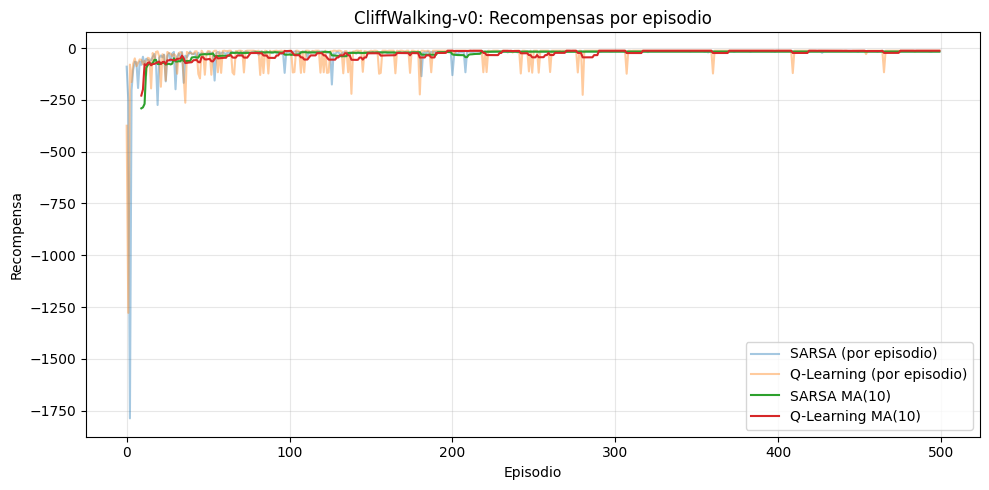

In [40]:
def moving_average(x, w=10):
    if len(x) < w: 
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(rewards_sarsa, label="SARSA (por episodio)", alpha=0.4)
plt.plot(rewards_ql, label="Q-Learning (por episodio)", alpha=0.4)

ma_w = 10
plt.plot(range(ma_w-1, len(rewards_sarsa)), moving_average(rewards_sarsa, ma_w), label=f"SARSA MA({ma_w})")
plt.plot(range(ma_w-1, len(rewards_ql)), moving_average(rewards_ql, ma_w), label=f"Q-Learning MA({ma_w})")

plt.title("CliffWalking-v0: Recompensas por episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Pruebas con distintos hiperparámetros**

In [ ]:
alphas          = [0.3, 0.5]
gammas          = [0.95, 0.99]

fixed_epsilons  = [0.01]

# ε con decaimiento 
decay_schedules = [
    {"start": 0.1, "end": 0.01, "decay_episodes": 300},
]

resultados = []

for alpha in alphas:
    for gamma in gammas:

        for epsilon in fixed_epsilons:
            print(f"\n== [FIXED] α={alpha} | γ={gamma} | ε={epsilon} ==")

            rewards_sarsa, Q_sarsa = train_sarsa(
                env,
                episodes=EPISODES,
                alpha=alpha,
                gamma=gamma,
                epsilon=epsilon,
                max_steps=500,
                epsilon_schedule=None,   
                seed=SEED
            )

            rewards_ql, Q_ql = train_q_learning(
                env,
                episodes=EPISODES,
                alpha=alpha,
                gamma=gamma,
                epsilon=epsilon,
                max_steps=500,
                epsilon_schedule=None,   
                seed=SEED
            )

            resultados.append({
                "alpha": alpha,
                "gamma": gamma,
                "epsilon_mode": "fixed",
                "epsilon": epsilon,              
                "sarsa_rewards": rewards_sarsa,
                "sarsa_Q": Q_sarsa,
                "ql_rewards": rewards_ql,
                "ql_Q": Q_ql
            })

        for sch in decay_schedules:
            eps0, epsf, dec = sch["start"], sch["end"], sch["decay_episodes"]
            eps_sched = make_epsilon_schedule(eps0, epsf, dec)

            print(f"\n== [DECAY] α={alpha} | γ={gamma} | ε={eps0}→{epsf} ({dec}) ==")

            rewards_sarsa, Q_sarsa = train_sarsa(
                env,
                episodes=EPISODES,
                alpha=alpha,
                gamma=gamma,
                epsilon=eps0,               
                max_steps=500,
                epsilon_schedule=eps_sched,  
                seed=SEED
            )

            rewards_ql, Q_ql = train_q_learning(
                env,
                episodes=EPISODES,
                alpha=alpha,
                gamma=gamma,
                epsilon=eps0,
                max_steps=500,
                epsilon_schedule=eps_sched,  
                seed=SEED
            )

            resultados.append({
                "alpha": alpha,
                "gamma": gamma,
                "epsilon_mode": "decay",
                "epsilon_start": eps0,
                "epsilon_end": epsf,
                "epsilon_decay_episodes": dec,
                "sarsa_rewards": rewards_sarsa,
                "sarsa_Q": Q_sarsa,
                "ql_rewards": rewards_ql,
                "ql_Q": Q_ql
            })



== [FIXED] α=0.3 | γ=0.95 | ε=0.01 ==

== [DECAY] α=0.3 | γ=0.95 | ε=0.1→0.01 (300) ==

== [FIXED] α=0.3 | γ=0.99 | ε=0.01 ==

== [DECAY] α=0.3 | γ=0.99 | ε=0.1→0.01 (300) ==

== [FIXED] α=0.5 | γ=0.95 | ε=0.01 ==

== [DECAY] α=0.5 | γ=0.95 | ε=0.1→0.01 (300) ==

== [FIXED] α=0.5 | γ=0.99 | ε=0.01 ==

== [DECAY] α=0.5 | γ=0.99 | ε=0.1→0.01 (300) ==


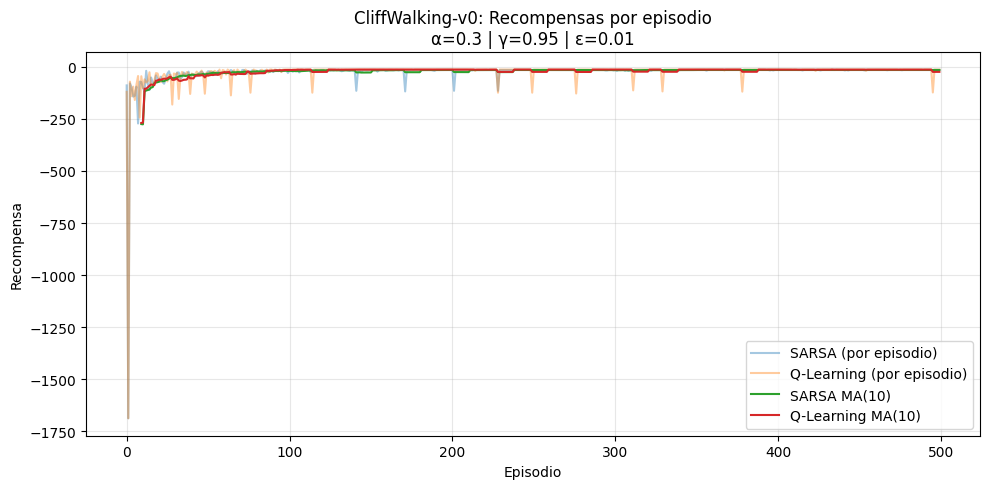

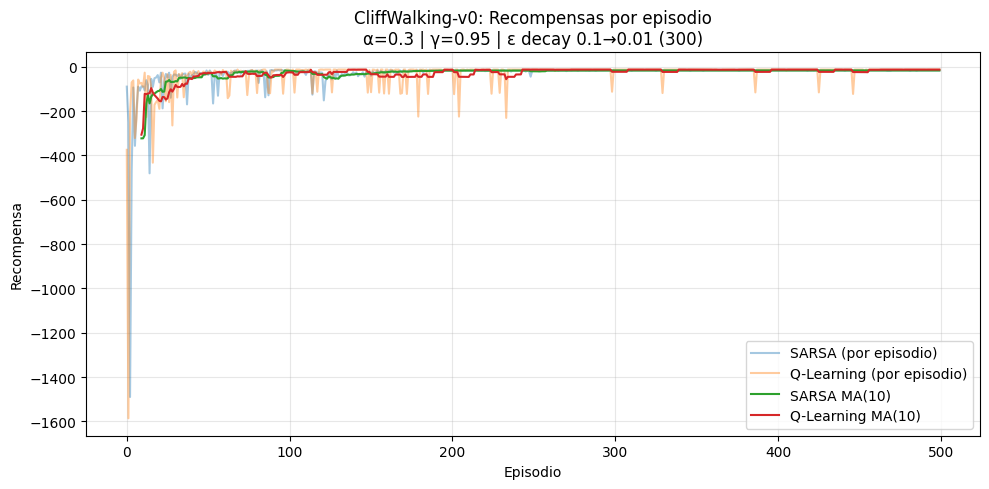

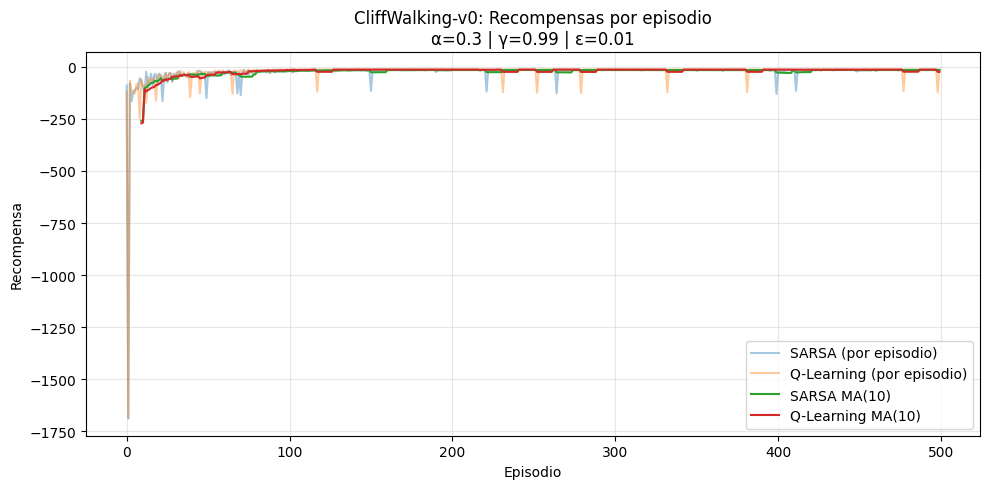

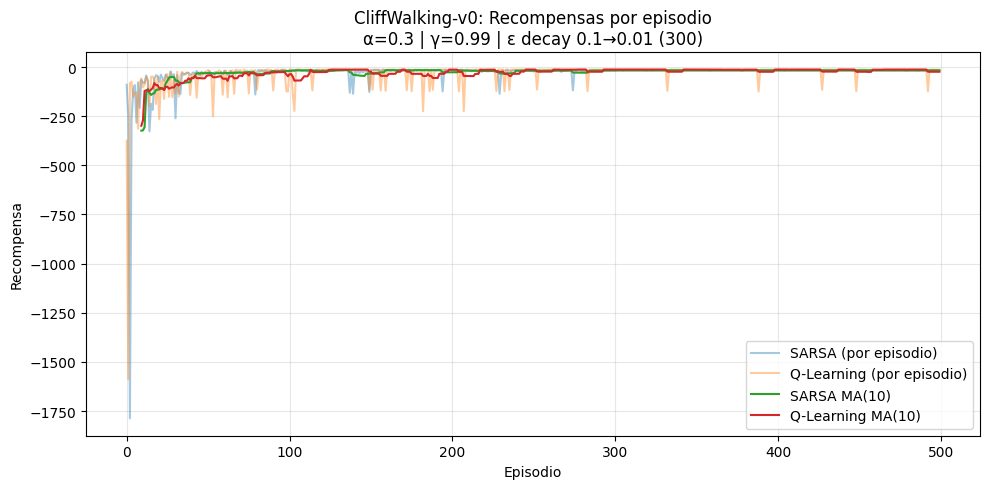

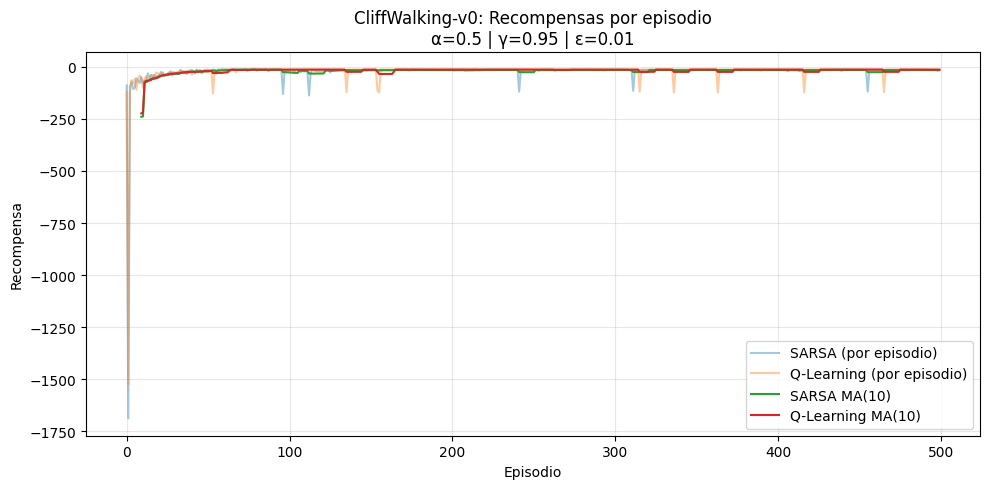

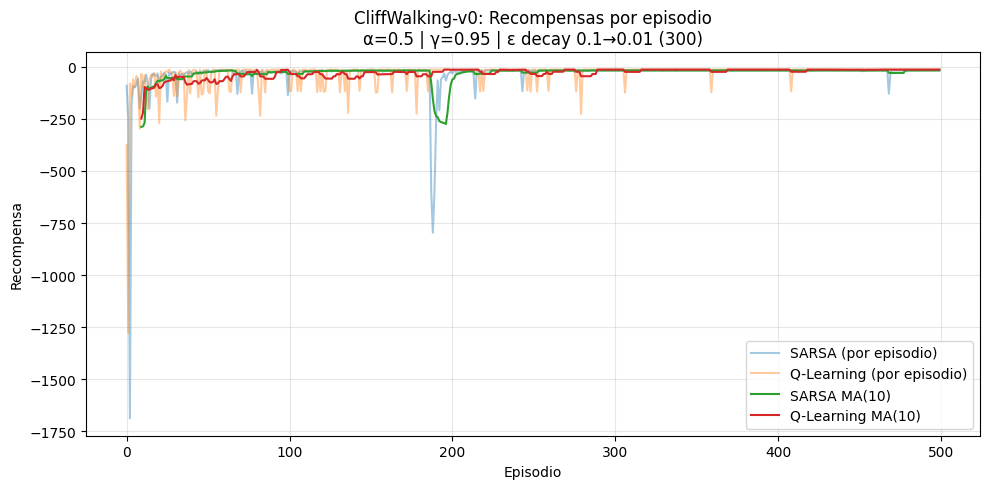

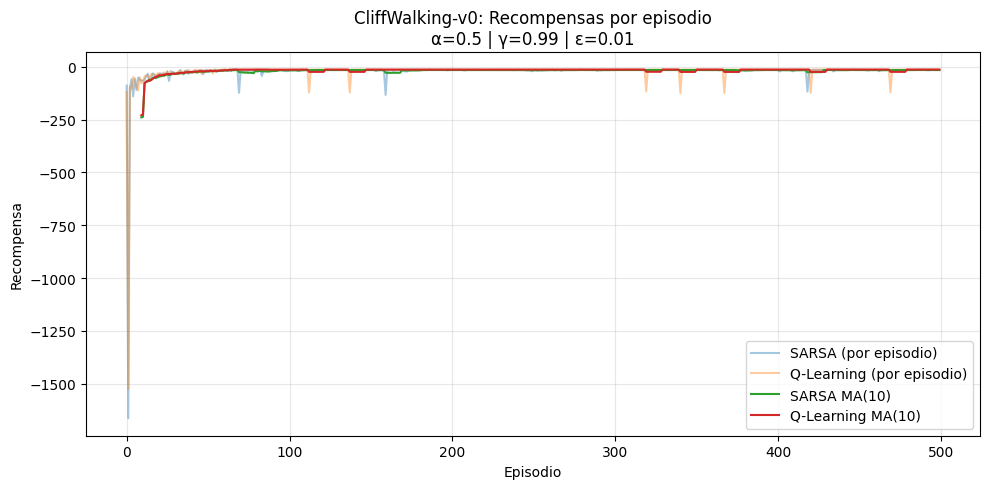

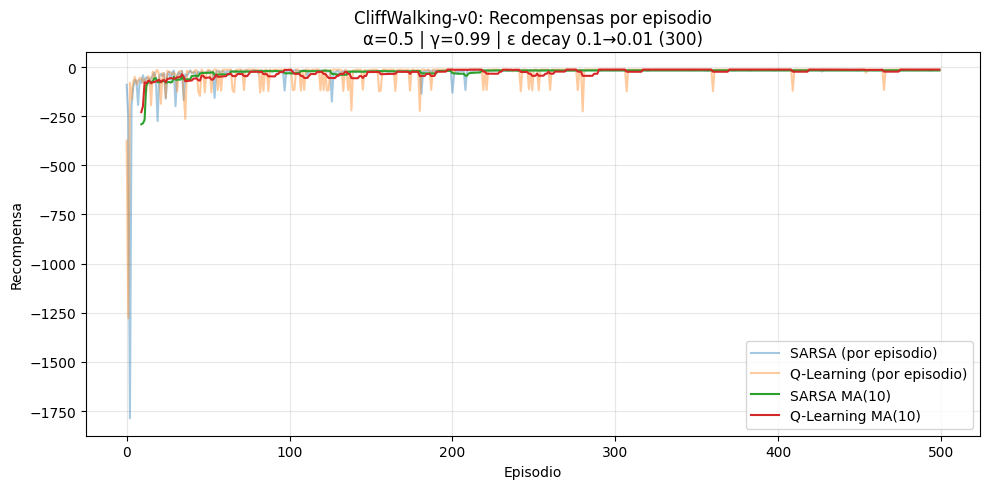

In [ ]:
def plot_experiment_curves(resultados, ma_w=10):
    import numpy as np
    import matplotlib.pyplot as plt

    def moving_average(x, w=10):
        x = np.asarray(x, dtype=float)
        if len(x) < w:
            return x
        return np.convolve(x, np.ones(w)/w, mode='valid')

    for rec in resultados:
        rewards_sarsa = np.asarray(rec["sarsa_rewards"], dtype=float)
        rewards_ql    = np.asarray(rec["ql_rewards"], dtype=float)

        if rec.get("epsilon_mode") == "fixed":
            eps_label = f"ε={rec['epsilon']}"
        elif rec.get("epsilon_mode") == "decay":
            eps_label = f"ε decay {rec['epsilon_start']}→{rec['epsilon_end']} ({rec['epsilon_decay_episodes']})"
        elif "epsilon" in rec:  
            eps_label = f"ε={rec['epsilon']}"
        else:
            eps_label = "ε (no especificado)"

        plt.figure(figsize=(10,5))
        plt.plot(rewards_sarsa, label="SARSA (por episodio)", alpha=0.4)
        plt.plot(rewards_ql,   label="Q-Learning (por episodio)", alpha=0.4)

        if len(rewards_sarsa) >= ma_w:
            plt.plot(range(ma_w-1, len(rewards_sarsa)),
                     moving_average(rewards_sarsa, ma_w),
                     label=f"SARSA MA({ma_w})")
        if len(rewards_ql) >= ma_w:
            plt.plot(range(ma_w-1, len(rewards_ql)),
                     moving_average(rewards_ql, ma_w),
                     label=f"Q-Learning MA({ma_w})")

        plt.title(f"CliffWalking-v0: Recompensas por episodio\nα={rec['alpha']} | γ={rec['gamma']} | {eps_label}")
        plt.xlabel("Episodio")
        plt.ylabel("Recompensa")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


plot_experiment_curves(resultados, ma_w=10)

**Analice los resultados**

**a. Observe los resultados graficados y compare el rendimiento de SARSA y Q-Learning a lo largo de los episodios.**

- Respuesta

**b. Considere cómo cada algoritmo equilibra la exploración y la explotación.**

- Respuesta


**Responda las siguientes preguntas:**

**a. P1: ¿Qué diferencias observa en los patrones de recompensa entre SARSA y Q-Learning?**

- Respuesta

**b. P2: ¿Por qué Q-Learning tiende a ser más optimista en sus actualizaciones de valor Q en comparación con SARSA?**

- Respuesta

**c. P3: ¿Cómo afecta la naturaleza "on-policy" de SARSA a su proceso de aprendizaje en comparación con la naturaleza "off-policy" de Q-Learning?**

- Respuesta

**d. P4: Según las penalizaciones y recompensas del entorno, ¿qué algoritmo parece aprender el camino más seguro? ¿Por qué?**

- Respuesta

**e. P5: ¿Cómo podría afectar la disminución de épsilon con el tiempo al rendimiento de cada algoritmo?**

- Respuesta


**Preguntas para responder:**

**1. ¿Cuál es el valor estimado de mantener diferentes niveles de existencias para cada producto?**

- Respuesta

**2. ¿Cómo afecta el valor epsilon en la política blanda al rendimiento?**

- Respuesta

**3. ¿Cuál es el impacto de utilizar el aprendizaje fuera de la política en comparación con el aprendizaje dentro de la política?**

- Respuesta
